# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Overview and Table of Content

The notebook will implement this workflow:

1. [Prepare jupyter lab notebook environment](#Prepare-jupyter-lab-notebook-environment)
1. [Download Data](#Download-Data)
1. [Data exploration and cleaning](#Data-exploration-and-cleaning)
    1. explore the data
    1. cleaning (handling null and empty values, unknown values, encode categorical values)
1. [Visualizations](#Visualizations)
    1. correlation studies
1. [Data preparation and transformation](#Data-preparation-and-transformation)
    1. Feature engineering (PCA)
1. [Model development and training](Model-development-and-training)
    1. Develop a model
    1. Train a model
    1. Model validation and evaluation
    1. Hyperparameters tuning
    1. Select the best performing model based on the test results
1. [Deploy model](#Deploy-Model)

# Prepare jupyter lab notebook environment
---


In [1]:
#restart kernel
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
!python --version

Python 3.9.6


In [ ]:
! conda update -y conda

In [ ]:
! conda update --all -y

In [ ]:
! conda install -y -c anaconda progressbar2

In [ ]:
#! conda install -y scikit-learn-intelex

In [ ]:
! conda list

## Imports and global configs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

In [5]:
# display the N columns and rows
pd.set_option('display.max_columns', 50)

pd.set_option('display.max_rows', 100)

## Activate intelex for scikit
see [activate intelex for scikit](https://intel.github.io/scikit-learn-intelex/index.html)

# Download Data
---
The four data sets
- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).
    
and two files of description    
- `DIAS Attributes - Values 2017.xlsx`
- `DIAS Information Levels - Attributes 2017.xlsx`

can be downloaded from the Udacity project workspace.

# Data exploration and cleaning
---

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load Data from S3
The load script assumes that the downloaded data has been transferred to S3.

The data load of the AZDIAS data set takes more than a minute the CUSTOMERS data set should be loaded in less than 20 secs


In [6]:
import os
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    prefix = 's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'

In [7]:
! aws s3 ls s3://sagemaker-eu-central-1-292575554790/dsnd_arvato/

Unable to locate credentials. You can configure credentials by running "aws configure".


In [8]:
%%time
df_azdias = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
# load in the data
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Stephan.Bauer\AppData\Local\Continuum\anaconda3\envs\py39_dsnd\lib\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 50.5 s


In [9]:
%%time
df_customers = pd.read_csv(f'{prefix}/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')

Wall time: 9.46 s


In [10]:
df_azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,...,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,...,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,...,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,...,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,...,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.4+ GB


In [12]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Columns: 368 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(8)
memory usage: 539.5+ MB


## Checks 
### Data errors during load
during the load process we got two error messages for columns 18 and 19. I will check this here

In [13]:
df_azdias.iloc[:,17:19].value_counts()

CAMEO_DEUG_2015  CAMEO_INTL_2015
9                51                 47054
9.0              51.0               34202
7                41                 34077
6                43                 32730
4                24                 32717
2                14                 31662
8                51                 30522
7.0              41.0               24825
6.0              43.0               23942
4.0              24.0               23672
2.0              14.0               22834
8.0              51.0               21916
3                24                 20165
                 25                 19781
8                41                 19382
4                22                 19173
8                54                 17965
3.0              24.0               14604
                 25.0               14526
8.0              41.0               14052
4.0              22.0               13982
8.0              54.0               13028
6                45                 12504
9

In [14]:
df_customers.iloc[:,17:19].value_counts()

CAMEO_DEUG_2015  CAMEO_INTL_2015
2                14                 12198
4                24                  8391
6                43                  7158
1                15                  6845
3                25                  5980
7                41                  5617
4                22                  5566
3                24                  4910
2.0              14.0                4086
5                34                  3945
8                51                  3164
6                45                  3160
1                13                  3143
8                41                  2844
9                51                  2823
2                12                  2791
4.0              24.0                2786
3                23                  2695
2                13                  2585
1                14                  2510
6.0              43.0                2476
1.0              15.0                2372
6                44                  2144
3

<div style="background-color:#bdedff;color:#00000">
<b>Result:</b> The errors is caused by string values "X" and "XX" in the datasets in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
<p> we will add some code to the Data Cleaner class to handle this
</div>

### check for duplicates
check if dataset contains duplicate records based on column ID LNR

In [15]:
df_azdias.index.duplicated().sum()

0

In [16]:
df_customers.index.duplicated().sum()

0

## Loading & Explore Metadata

### Load Metadata

In [17]:
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')
df_metadata.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


### Explore Metadata

1. check nulls
2. check unkown values

In [18]:
df_metadata.isnull().sum()

Attribute      0
Description    0
Value          0
Meaning        0
dtype: int64

In [19]:
f"Number of unique attributes: {df_metadata['Attribute'].unique().shape[0]}"

'Number of unique attributes: 314'

In [20]:
f"Number of Attributes that can be unnkown value: {df_metadata['Meaning'].str.contains('unknown').sum()}"

'Number of Attributes that can be unnkown value: 233'

In [21]:
f"Number of Attributes that can be `no transaction known` value: {df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}"

'Number of Attributes that can be `no transaction known` value: 56'

In [22]:
f"Total: {df_metadata['Meaning'].str.contains('unknown').sum() + df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}"

'Total: 289'

### Compare dataset features (columns)

In [23]:
# columns that customers dataset contain but azidas not
set(df_customers.columns) - set(df_azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [24]:
# columns that azdias dataset contain but customers not
set(df_azdias.columns) - set(df_customers.columns)

set()

### Metadata Columns compared to Dataset columns

In [25]:
df_metadata_cols = df_metadata['Attribute'].copy()
# some columns of the metadata ends on _RZ whereas the datasets have the same columns whcih do not end on _RZ
# therefore we replace this
df_metadata_cols = df_metadata_cols.str.replace('_RZ','')

diff_set = set(df_azdias.columns) - set(df_metadata_cols)
print(f'number of cols in AZDIAS dataset but not described in Metadata: {len(diff_set)}')
pd.Series(list(diff_set)).sort_values()

number of cols in AZDIAS dataset but not described in Metadata: 60


8                     AKT_DAT_KL
21          ALTERSKATEGORIE_FEIN
2                    ALTER_KIND1
6                    ALTER_KIND2
54                   ALTER_KIND3
58                   ALTER_KIND4
51                    ANZ_KINDER
13    ANZ_STATISTISCHE_HAUSHALTE
7                         ARBEIT
30               CAMEO_INTL_2015
56             CJT_KATALOGNUTZER
14                     CJT_TYP_1
43                     CJT_TYP_2
50                     CJT_TYP_3
36                     CJT_TYP_4
20                     CJT_TYP_5
9                      CJT_TYP_6
16                   D19_BUCH_CD
48             D19_KONSUMTYP_MAX
19      D19_LETZTER_KAUF_BRANCHE
28                  D19_SOZIALES
57     D19_TELKO_ONLINE_QUOTE_12
35               D19_VERSI_DATUM
27       D19_VERSI_OFFLINE_DATUM
39        D19_VERSI_ONLINE_DATUM
15     D19_VERSI_ONLINE_QUOTE_12
11                      DSL_FLAG
17                 EINGEFUEGT_AM
42          EINGEZOGENAM_HH_JAHR
18                     EXTSEL992
29        

In [26]:
diff_set2 = set(df_metadata_cols) - set(df_azdias.columns)
print(f'number of cols in Metadata but not in AZDIAS dataset: {len(diff_set2)}')
diff_set2

number of cols in Metadata but not in AZDIAS dataset: 9


{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BUCH',
 'D19_KK_KUNDENTYP',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [27]:
df_azdias[list(diff_set)].head()

,VK_DHT4A,RT_UEBERGROESSE,ALTER_KIND1,RT_SCHNAEPPCHEN,RT_KEIN_ANREIZ,GEMEINDETYP,ALTER_KIND2,ARBEIT,AKT_DAT_KL,CJT_TYP_6,KBA13_ANTG1,DSL_FLAG,UMFELD_JUNG,ANZ_STATISTISCHE_HAUSHALTE,CJT_TYP_1,D19_VERSI_ONLINE_QUOTE_12,D19_BUCH_CD,EINGEFUEGT_AM,EXTSEL992,D19_LETZTER_KAUF_BRANCHE,CJT_TYP_5,ALTERSKATEGORIE_FEIN,MOBI_RASTER,SOHO_KZ,KBA13_GBZ,...,D19_VERSI_DATUM,CJT_TYP_4,VHA,KONSUMZELLE,D19_VERSI_ONLINE_DATUM,VHN,KBA13_ANTG2,EINGEZOGENAM_HH_JAHR,CJT_TYP_2,STRUKTURTYP,KBA13_BAUMAX,KOMBIALTER,KBA13_ANTG4,D19_KONSUMTYP_MAX,VK_ZG11,CJT_TYP_3,ANZ_KINDER,KBA13_KMH_210,KBA13_HHZ,ALTER_KIND3,VERDICHTUNGSRAUM,CJT_KATALOGNUTZER,D19_TELKO_ONLINE_QUOTE_12,ALTER_KIND4,HH_DELTA_FLAG
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,NaN,1.0,NaN,4.0,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,1.0,NaN,0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,10,5.0,NaN,NaN,10,NaN,NaN,NaN,1.0,NaN,NaN,9,NaN,9,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
910220,8.0,5.0,NaN,3.0,5.0,22.0,NaN,3.0,9.0,1.0,2.0,1.0,3.0,12.0,5.0,NaN,0,1992-02-10 00:00:00,NaN,NaN,1.0,21.0,1.0,1.0,4.0,...,10,3.0,0.0,1.0,10,4.0,4.0,2004.0,5.0,2.0,2.0,1,1.0,9,10.0,2.0,0.0,4.0,5.0,NaN,0.0,1.0,NaN,NaN,0.0
910225,9.0,5.0,NaN,4.0,5.0,22.0,NaN,3.0,9.0,2.0,2.0,1.0,5.0,7.0,4.0,0.0,0,1992-02-12 00:00:00,14.0,D19_UNBEKANNT,2.0,17.0,2.0,0.0,4.0,...,10,3.0,0.0,0.0,10,2.0,3.0,2000.0,4.0,3.0,1.0,2,0.0,8,6.0,1.0,0.0,4.0,4.0,NaN,1.0,2.0,0.0,NaN,0.0
910226,7.0,3.0,NaN,2.0,3.0,40.0,NaN,2.0,1.0,3.0,2.0,1.0,5.0,2.0,2.0,0.0,6,1997-04-21 00:00:00,31.0,D19_UNBEKANNT,5.0,13.0,4.0,0.0,4.0,...,10,4.0,1.0,0.0,10,0.0,3.0,1998.0,2.0,1.0,1.0,4,0.0,8,11.0,4.0,0.0,2.0,3.0,NaN,0.0,3.0,0.0,NaN,NaN
910241,3.0,5.0,NaN,5.0,3.0,21.0,NaN,4.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,0.0,6,1992-02-12 00:00:00,NaN,D19_SCHUHE,3.0,14.0,1.0,0.0,3.0,...,2,4.0,0.0,0.0,10,2.0,4.0,2004.0,3.0,3.0,2.0,3,1.0,1,4.0,3.0,0.0,3.0,3.0,NaN,1.0,3.0,0.0,NaN,0.0


### Extract `Kinder` information and build new feature
we use the ANZ_KINDER and ALTER_KIND(n) columns to derive the number of children <10 and >= 10

number of records with more than 4 children: 252 of 891,221 (0.02828 %)
number of records with at least one child: 86480 of 891,221 (9.70354 %)
number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: 9

--------------------------------------------------------------------------------


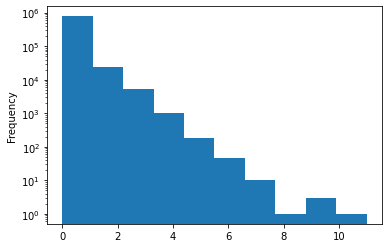

In [25]:
num_moreThan4Children = df_azdias[df_azdias['ANZ_KINDER']>4].shape[0]
num_withChildren = df_azdias[df_azdias['ANZ_KINDER']>0].shape[0]
df_children5plus = df_azdias[(df_azdias['ANZ_KINDER']>4) & (df_azdias['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_azdias.shape[0]:,.0f} ({(num_moreThan4Children / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_azdias.shape[0]:,.0f} ({(num_withChildren / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)

ax = df_azdias['ANZ_KINDER'].plot.hist()
ax.set_yscale('log')

**Result** The query above shows that there just 9 records with more or equal than 5 children and an age of child4 (`ALTER_KIND4`) < 10. In addition the `ALTER_KIND` column values are ordered so we can assume that the age of child5 and higher is >= 10

number of records with more than 4 children: 54 of 191,652 (0.02818 %)
number of records with at least one child: 12772 of 191,652 (6.66416 %)
number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: 2

--------------------------------------------------------------------------------


Text(0.5, 0, 'number of children')

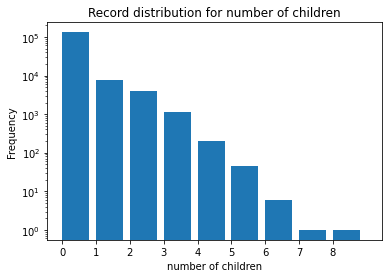

In [26]:
num_moreThan4Children = df_customers[df_customers['ANZ_KINDER']>4].shape[0]
num_withChildren = df_customers[df_customers['ANZ_KINDER']>0].shape[0]
df_children5plus = df_customers[(df_customers['ANZ_KINDER']>4) & (df_customers['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_customers.shape[0]:,.0f} ({(num_moreThan4Children / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_customers.shape[0]:,.0f} ({(num_withChildren / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)

max_children = int(df_customers['ANZ_KINDER'].max())
ax = df_customers['ANZ_KINDER'].plot.hist(bins=range(max_children+2), width=0.8)
ax.set_yscale('log')
ax.set_xticks(range(0,max_children+1));
ax.set_title('Record distribution for number of children');
ax.set_xlabel('number of children')

### Metadata Summary

The value *"unkown"* will be treated like a missing value.

The value *"no transaction(s) known"* will be treated as if the customer has done no transaction


# Class Cleaner
----

In [289]:
class DFCleaner:
    """
    This class will provide some functionality to clean a data set
    """
    def __init__(self, df_metadata):
        """
        inits the class.
        
        Parameters
        ----------
            df_metadata: pd.DataFrame
                pandas dataframe with the loaded data from file "DIAS Attributes - Values 2017.xlsx". Containing
                information about the attribute values.
        """
        self.df_metadata = df_metadata

        # replace the metadata attribute column ending "_RZ" by "" in order to match the dataset column names
        self.df_metadata['Attribute'] = self.df_metadata['Attribute'].str.replace('_RZ','')

    
    def transform(self, df):
        """
        executes the data transformation (cleaning)
        """        
        df = self.__mark_nans(df)        
        df = self.__handle_data_load_errors(df)
        df = self.__catvars_to_dummies(df)        
        df = self.__catvars_to_binary(df)        
        df = self.__drop_columns(df)        
        return df
    
    def fit (self, df):
        """
        prepare data for transformation
        """

        pass
    
    def __handle_data_load_errors(self, df):
        """
        handles the errors fo columns 18 and 19 of dtype float that contain two 18,19 
        """
        cols_to_fix = {'CAMEO_DEUG_2015':'X', 'CAMEO_INTL_2015':'XX'}

        print(f'fixing load errors {cols_to_fix}')

        for col, val in cols_to_fix.items():
            n = df.loc[df[col] == val].shape[0]
            df.loc[df[col] == val, col] = np.NaN
            df.loc[:,col] = df.loc[:,col].astype('float')

            print(f'fixed column {col} - records fixed: {n}')
        
        return df


    def __drop_columns(self, df, columns_to_drop=None):
        # if columns to drop have been defined then use them 
        # else execute the default cleaning
        if columns_to_drop:            
            cols_to_drop = columns_to_drop
        else:
            cols_to_drop = ['EINGEFUEGT_AM'] 

        print(f'dropping columns: {cols_to_drop}')                

        try:
            df.drop(labels=cols_to_drop, axis=1, inplace=True)   
        except KeyError as ex_keyerror:
            print(f'CATCHED EXCEPTION: KeyError: you tried to drop non existing columns: {cols_to_drop}')
            print(f'Failed columns: {ex_keyerror.args}')

        return df     

    def __catvars_to_dummies(self, df):
        """
        handles categorical variables. This will generate one hot encodings for the defined columns
        """
        cat_cols = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']

        print('creating one hot encoding columns for: ')
        for col in cat_cols:
            print(f'\t{col}')

        # create one hot encodings using pandas get_dummies function
        df_dummies = pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=True).astype('int64')
        df = pd.concat([df, df_dummies], axis=1)
        
        # drop original columns
        df.drop(cat_cols, axis=1, inplace=True)

        return df

    def __catvars_to_binary(self, df):
        cat_cols = {'OST_WEST_KZ':{'W':0,'O':1}}

        print('convert to binary: ')
        for col, dict_map in cat_cols.items():
            print(f'\tcolumn: {col} - Mapping: {dict_map}')
            df.loc[:,col] = df.loc[:,col].map(dict_map)

        return df



    def __mark_nans(self, df):
        """
        replaces all unkown values by np.NAN so that the pandas NAN functions can be used.

        Parameters
        ----------

            df : pd.DataFrame
                pandas DataFrame that is to be cleaned. Frame is expected to have columns as AZDIAS or CUSTOMERS                
        """       

        print('replace unkown values by NaNs: ') 
        unknown_val_set = df_metadata.copy()
        unknown_val_set = unknown_val_set[unknown_val_set['Meaning'].str.contains('unknown')]
        unknown_val_set['value_list']  = unknown_val_set['Value'].str.split(',')
        
        #with progressbar.ProgressBar(max_value=unknown_val_set.index.shape[0]) as bar:
        cnt = 0
        max_value=unknown_val_set.index.shape[0]
        for idx in unknown_val_set.index:
            col  = unknown_val_set.loc[idx,'Attribute']
            vals = unknown_val_set.loc[idx,'value_list']
            # str convert to integers
            vals = list(map(int,vals))
            if col in df:
                df.loc[df[col].isin(vals),col] = np.NaN

            cnt += 1
            if (cnt == max_value) or (cnt % (max_value // 10)==0):
                print(f'\tProcessed columns\r{cnt:4} of {max_value}', end='')
        
        print()
        return df
                                    
    @property
    def df_metadata(self):
        return self.__df_metadata
    
    @df_metadata.setter
    def df_metadata(self, val):
        self.__df_metadata = val
        

class FeatureBuilder:
    def __init__(self):
        pass

    def transform(self, df):
        """
        executes the data transformation 

        Parameters
        ----------
            df : pd.DataFrame
                pandas DataFrame that is to be cleaned. Frame is expected to have columns as AZDIAS or CUSTOMERS                


        """
        self.__build_features_chidren(df)
    
    def fit (self, df):
        """
        prepare data for transformation
        """
        pass

    def __build_features_chidren(self, df):
        """
        This function will build some features based on the given input data

        * Children and Teens: 
            * Children:= number of children younger or equal than 10
            * Teens   := number of children older or equal than 10

        Parameters
        ----------
            df : pd.DataFrame
                pandas DataFrame that is to be cleaned. Frame is expected to have columns as AZDIAS or CUSTOMERS                
        """
        #df['d_NUM_CHILDREN_LESS_10'] = 0
        #df['d_NUM_CHILDREN_GTE_10'] = 0
        df['d_HAS_CHILDREN'] = 0
        df['d_HAS_CHILDREN_YTE10'] = 0
        
        cols = ['ANZ_KINDER','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4',
                #'d_NUM_CHILDREN_LESS_10','d_NUM_CHILDREN_GTE_10',
                'd_HAS_CHILDREN', 'd_HAS_CHILDREN_YTE10'
                ]

        #df.loc[df['ANZ_KINDER'] > 0,cols] = df.loc[df['ANZ_KINDER'] > 0,cols].apply(self.__calc_child_and_teens,'columns')
        df.loc[df['ANZ_KINDER'] > 0,cols] = df.loc[df['ANZ_KINDER'] > 0,cols].apply(self.__calc_children_features,'columns')
        df.drop('')
        


    def __calc_children_features(self, s):
        """
        Description
        -----------

            * checks if person has children ANZ_KINDER>0
            * checks if person has at least one children <= 10            

        """        
        yte_10 = (s[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']] <= 10).sum()
        

        s['d_HAS_CHILDREN'] = s['ANZ_KINDER']>0
        s['d_HAS_CHILDREN_YTE10']  = yte_10>0
        
        return s

    def __calc_child_and_teens(self, s):
        """
        counts the number of children less 10 and greater equal than 10. I assume that for more than 5 children
        all children > 4 are older than 10. Based on the analysis this is in general true
        """        
        less_10 = (s[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']] < 10).sum()
        gte_10 = s['ANZ_KINDER'] - less_10

        s['d_NUM_CHILDREN_LESS_10'] = less_10
        s['d_NUM_CHILDREN_GTE_10']  = gte_10
        
        return s
    



# Data Cleaning 
---

The `DataCleaner` class will handle the following:

* replace `unknown` values (represented by -1, 0, 9 see [Metadata Descriptions](#Loading-and-Explore-Metadata))
* handle the errors raised during the load
* handle categorical variables
* drop not needed columns

see sections below for details

In [291]:
TESTING = False
if TESTING:
    df_azdias_cleaned = df_azdias.iloc[:100,:].copy()
else:
    df_azdias_cleaned = df_azdias.copy()


## Handle Unknown / Missing Data

The dataset contains a lot of unkown values. Many times these values are encoded by -1, 0 or 9 (see Metadata files). I replace all unkown values by np.NaN to use standard pandas function for imputinig and dropping.



In [248]:
df_azdias_cleaned.shape

(891221, 440)

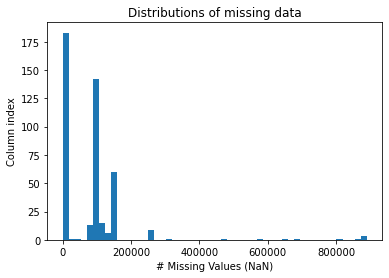

In [251]:
# Assess missing data in columns
plt.hist(df_azdias_cleaned.isnull().sum(axis=0), bins =50)
plt.title('Distributions of missing data')
plt.xlabel('# Missing Values (NaN)')
plt.ylabel('Column index');

Most columns have less than 25% missing values. Some columns have more than 50% missing data. Let's find them

In [256]:
num_of_records = df_azdias_cleaned.shape[0]
s_missing_data = df_azdias_cleaned.isnull().sum(axis=0)
s_missing_data_pct = df_azdias_cleaned.isnull().sum(axis=0) / num_of_records 

df_missing_data = pd.DataFrame({'abs':s_missing_data,'pct':s_missing_data_pct})
df_missing_data.sort_values(by='pct', ascending=False)[:20]


,abs,pct
ALTER_KIND4,890016,0.998648
TITEL_KZ,889061,0.997576
ALTER_KIND3,885051,0.993077
ALTER_KIND2,861722,0.966900
ALTER_KIND1,810163,0.909048
AGER_TYP,677503,0.760196
EXTSEL992,654153,0.733996
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
ALTER_HH,310267,0.348137


**Results**: 
* There 19 variables with more than 25% missing values -> These are candidates to drop
* There are some variables that have all the same number of missing data (257113 - D19_...).
* the variables `ALTER_KIND1` - `ALTER_KIND4` have a huge number of missing values. This is because they are dependent on `ANZ_KINDER` (number of children) so that for all records with `ANZ_KINDER`=0 the values for `ALTER_KIND1`- `ALTER_KIND4` are missing. We will handle this in feature engineering part and build a new varaible for these


**Note**: The drop operation will be the last part as columns maybe needed during the feature engineering process


In [257]:
drop_level = 0.25
columns_to_drop = s_missing_data_pct.sort_values(ascending=False)
columns_to_drop = columns_to_drop[columns_to_drop>drop_level].index
columns_to_drop

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'ALTER_HH',
       'ALTERSKATEGORIE_FEIN', 'D19_KONSUMTYP', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_SOZIALES', 'D19_LOTTO'],
      dtype='object')

## Inverstigate  columns that throw an error

In [232]:
df_azdias_cleaned['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

Obviously the 'X' is causing the issue. I will replace this by np.NaN

In [233]:
df_azdias_cleaned['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

Obviously the 'XX' is causing the issue. I will replace this by np.NaN

## Handle Categorical Values

The datasets have a huge number of categorical variables. Most of the categorical variables are already encoded by int and floats, e.g. `AGER_TYP` is encoded by

|value  | meaning |
|-----  |---------|
|-1     |	unknown |
|0	    | no classification possible |
|1	    | passive elderly |
|2	    | cultural elderly |
|3	    | experience-driven elderly |

We keep this encoding as in many cases the categorical values are Ordinal and just some nominal, e.g.

variable `D19_TELKO_ANZ_12` the values are ordered from `very low activity` to `very high activity`

|value  | meaning |
|-----  |---------|
|0      | no transactions known            |
|1      | very low activity                |
|2      | low activity                     |
|3      | slightly increased activity      |
|4      | increased activity               |
|5      | high activity                    |
|6      | very high activity               |


However, some columns are of type = object. These are now investigated.

In [226]:
df_azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.5+ GB


In [227]:
df_azdias_cleaned.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN
910220,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
910225,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
910226,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
910241,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


#### Results Categorical:

|variable   | type      | action    |
|--         |--         | ---   	|
|CAMEO_DEU_2015| nominal | replace by one hot encoding |
|D19_LETZTER_KAUF_BRANCHE | nominal | replace by one hot encoding |
| EINGEFUEGT_AM | date | drop - this is just the date when the record has been added |
| OST_WEST_KZ | nominal | replace by binary 0 and 1 |

`CAMEO_DEUG_2015` encoded categorical variable - contains invalid strings 'X'
`CAMEO_INTL_2015` encoded categorical variable - contains invalid strings 'XX'


In [243]:
pd.set_option('max_seq_items',450)
df_azdias_cleaned.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4',
       'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE

## Run the cleaning process

In [234]:
dfCleaner = DFCleaner(df_metadata)

df_azdias_cleaned = dfCleaner.transform(df_azdias_cleaned)
df_azdias_cleaned.shape

replace unkown values by NaNs: 
 233 of 233
fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 373
fixed column CAMEO_INTL_2015 - records fixed: 373
creating one hot encoding columns for: 
	CAMEO_DEU_2015
	D19_LETZTER_KAUF_BRANCHE
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}
dropping columns: ['EINGEFUEGT_AM']


(891221, 440)

# Feature Engineering
Many records have ANZ_KINDER (number of children) = 0. 
For theses records the age of children columns (ALTER_KIND(N)) are always NaN. For records with a positive number 
of children the ALTER_KIND columns contains the age of children. We will replace these columns by summerize the
 them to two columns that will indicate the number of children younger than 10 and older or equal than 10.

In [292]:
df  = df_azdias_cleaned
cols_to_investigate = ['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','ANZ_KINDER']
df_kinder = df[cols_to_investigate]


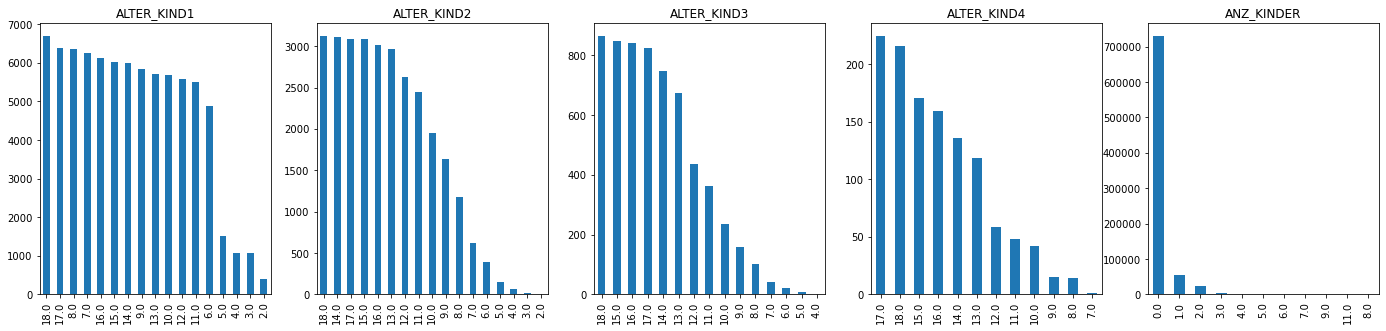

In [293]:
#df_kinder = df_azdias_cleaned.filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

figure, ax_list = plt.subplots(1,5,figsize=(24,5))

for i, col in enumerate(cols_to_investigate):
    df_kinder[col].value_counts().plot(kind='bar',ax=ax_list[i], title=col)

**Results**: The majority has no children. The dataset is quite imbalanced. Even the age of children is havily imbalanced. As you can see in chart `ALTER_KIND1` the distribution of ages has much higher values for >5 than for <=5

Based on the observations above I will build a new feature `d_has_children` and `d_has_children_yte10` to indicate that person has children younger or equal than 10.

In [297]:
df_azdias_cleaned.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,...,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,0,0
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,...,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,0,0
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,...,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,0,0
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,...,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,0,0
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,...,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,0,0


In [296]:
df_tmp = df_azdias_cleaned.iloc[:100,:].copy()
featureBuilder = FeatureBuilder()
#featureBuilder.transform(df_azdias_cleaned)
featureBuilder.transform(df_tmp)

KeyError: "[''] not found in axis"

In [295]:
df_azdias_cleaned.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,...,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,0,0
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,...,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,0,0
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,...,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,0,0
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,...,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,0,0
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,...,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,0,0


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')